In [72]:
import numpy as np
from astropy.table import Table,hstack,vstack,join
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import glob
import matplotlib.pyplot as plt
from scipy import constants
speedoflight = constants.c / 1000.0

datadir = '/n/holyscratch01/conroy_lab/vchandra/mage/'

with open('/n/home03/vchandra/outerhalo/08_mage/pipeline/control/redux.txt', 'r') as file:
    redux = file.read().replace('\n','')

def getdata(GaiaID = None, acat_id = None, date = None,
                mask_hbeta = False):    
    
    acat = Table.read(datadir + 'catalogs/mage_acat.fits')
    acat = acat.filled(99.0)
    
    if acat_id is not None:
        row = acat[acat['ACAT_ID'] == acat_id]
    elif GaiaID is not None and date is not None:
        row = acat[(acat['GAIAEDR3_ID'] == GaiaID) & (acat['date'] == date)]
    # elif index is not None:
    #     row = acat[acat['ACAT_ID'] == index][0]
    else:
        print('must pass either GaiaID+date or ACAT index!!')
        raise

    if len(row) == 1:
        row = row[0]
    elif len(row) == 0:
        print('no matches in table! cannot get data...')
        raise
    elif len(row) > 1:
        print('getdata query does not return unique row in ACAT')
        raise
    
    filepath = row['specfile']

    with fits.open(filepath) as f:

        wave = f[1].data['wave']
        flux = f[1].data['flux']
        ivar = f[1].data['ivar']
        mask = f[1].data['mask']

    ivar[mask == 0] = 0

    cond = (
        np.isfinite(flux) & 
        (ivar > 0.0) & 
        (wave > 4800) &
        (wave < 5500.0) &
        (ivar > 0)
    )

    wave   = wave[cond]
    flux   = flux[cond]
    ivar = ivar[cond]
    mask = mask[cond]

    res_p = np.loadtxt('/n/home03/vchandra/outerhalo/08_mage/pipeline/control/res_sigma_p.txt')
    wresl = res_p[0] * wave + res_p[1]

    medflux = np.median(flux)

    flux /= medflux
    ivar *= medflux**2

    return {'phot':row,'spec': {'wave': wave,
                                'flux': flux,
                                'ivar': ivar,
                                'wresl': wresl}}

In [73]:
data = getdata(acat_id = 0)

In [74]:
data['phot']['GAIAEDR3_G']

18.064178

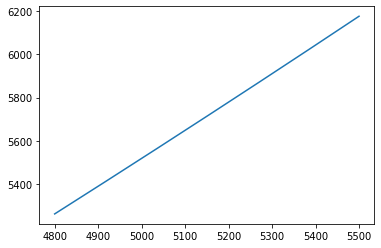

In [75]:
plt.plot(data['spec']['wave'], data['spec']['wave'] / (data['spec']['wresl'] * 2.355))

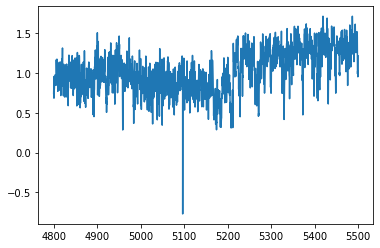

In [76]:
plt.plot(data['spec']['wave'], data['spec']['flux'])

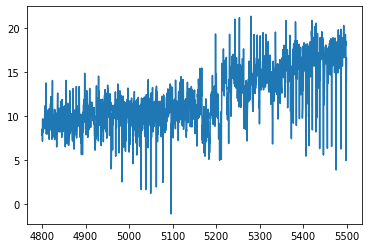

In [77]:
plt.plot(data['spec']['wave'], data['spec']['flux'] * np.sqrt(data['spec']['ivar']))